In [1]:
import cloudpickle as pickle
import sys


# sys.path.append("/home/luliqiang/python-cnn-tools-test/QuCT-Micro2023")

from openpyxl import Workbook
from downstream.fidelity_predict.evaluate_tools import plot_top_ratio
from plot.plot import get_duration2circuit_infos
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration, get_couple_prop
from circuit.utils import make_circuitlet
# from generate_dataset import gen_train_dataset
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path, plot_correlation, plot_real_predicted_fidelity
import random
import numpy as np
import ray
# from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator, get_random_erroneous_pattern
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle
import os
from sklearn.model_selection import train_test_split
from scipy import io as sio
from qiskit import QuantumCircuit
with open(f"execute_18bit/upstream_model_18_0_2500.pkl","rb")as f:
    _upstream_model = pickle.load(f)
    
res_500_2500 = sio.loadmat("execute_18bit/measure_results_20230322_500_2500.mat")
res_0_500 = sio.loadmat("execute_18bit/measure_results_20230321.mat")
all_results_load = {**res_0_500, **res_500_2500}

dataset = _upstream_model.dataset
assert len(dataset) == 2500

In [11]:
bad = 0
filter_bad_dataset = []
label = []
for i in range(2500):
    state_count = dict([(s, cnt) for s, cnt in zip(
                    np.squeeze(all_results_load[f'circuit No.{i} state_index']), 
                    np.squeeze(all_results_load[f'circuit No.{i} measure_counts']))])
    if 0 in state_count:
        filter_bad_dataset.append(dataset[i])
        label.append(state_count[0] / 1000)
        print(i, state_count[0])
    else:
        bad += 1

0 442
1 508
2 427
3 441
4 386
5 479
6 471
7 468
8 468
9 482
10 392
11 450
12 398
13 489
14 458
15 417
16 393
17 458
18 471
19 480
20 436
21 473
22 380
23 220
24 460
25 449
26 374
27 425
28 404
29 382
30 407
31 404
32 351
33 361
34 446
35 463
36 466
37 381
38 427
39 446
40 456
41 428
42 460
43 417
44 318
45 381
46 455
47 443
48 385
49 358
50 424
51 399
52 361
53 412
54 380
55 411
56 421
57 406
58 442
59 373
60 433
61 361
62 389
63 344
64 330
65 478
66 415
67 242
68 328
69 376
70 346
71 225
72 374
73 467
74 450
75 354
76 361
77 421
78 399
79 311
80 264
81 421
82 366
83 302
84 383
85 253
86 391
87 432
88 411
89 420
90 386
91 389
92 301
93 413
94 380
95 378
96 383
97 373
98 330
99 307
100 378
101 347
102 226
103 329
104 437
105 342
106 428
107 445
108 377
109 215
110 389
111 318
112 360
113 380
114 323
115 341
116 146
117 412
118 312
119 416
120 356
121 398
122 361
123 389
124 434
125 425
126 267
127 385
128 459
129 386
130 348
131 353
132 444
133 403
134 437
135 341
136 420
137 414
138 40

In [23]:
from circuit.formatter import layered_circuits_to_qiskit


qasm = []
qiskits = [] 
for cir in filter_bad_dataset:
    qc = layered_circuits_to_qiskit(18,cir['layer2gates'],barrier = False)
    qiskits.append(qc)
    qasm.append(qc.qasm())

In [38]:
t1 = sio.loadmat("T1.mat")
t2 = sio.loadmat("T2.mat")

In [42]:
t2
for ele in t2:
    if '_7' in ele:
        print(ele,t2[ele])

q11_7 [[20.25100554]]
q5_7 [[30.78749225]]
q3_7 [[22.97748905]]
q9_7 [[16.20445159]]
q7_7 [[21.55635081]]
q1_7 [[39.97713063]]


In [46]:
t1 = [143.00707506,173.83609431,194.26746865,116.13005113,172.04279259,176.46327618,
      161.10508785, 103.76419991, 165.3359516, 146.26499512, 188.11766842, 177.30488521,
      170.9790768, 113.21655646, 112.50055873, 113.97493521,  149.62797568, 176.46327618]

In [47]:
t2 =  [68.60893648, 23.66789366, 19.37538014, 26.07907702, 17.78826406, 24.78433159,
       39.97713063, 22.97748905, 30.78749225, 21.55635081, 46.71128332, 16.20445159,
       20.2089313, 21.5937426, 65.60053136, 46.71128332, 20.83485153, 37.17036482]

In [37]:
len(t1),len(t2)

(18, 17)

In [61]:
t1_t2 = {}
for i in range(18):
    qubit_i = {}
    qubit_i['T1'] = t1[i]
    qubit_i['T2'] = t2[i]
    qubit_i['prob_meas0_prep1'] = 0
    qubit_i['prob_meas1_prep0'] = 0
    t1_t2[i] = qubit_i

In [49]:
t1_t2

{0: {'T1': 143.00707506,
  'T2': 68.60893648,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 1: {'T1': 173.83609431,
  'T2': 23.66789366,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 2: {'T1': 194.26746865,
  'T2': 19.37538014,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 3: {'T1': 116.13005113,
  'T2': 26.07907702,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 4: {'T1': 172.04279259,
  'T2': 17.78826406,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 5: {'T1': 176.46327618,
  'T2': 24.78433159,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 6: {'T1': 161.10508785,
  'T2': 39.97713063,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 7: {'T1': 103.76419991,
  'T2': 22.97748905,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 8: {'T1': 165.3359516,
  'T2': 30.78749225,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 9: {'T1': 146.26499512,
  'T2': 21.55635081,
  'prob_meas0_prep1': 0,
  'prob_meas1_prep1': 0},
 10: {'T1': 188.11766842,
  'T2

In [50]:
single_average_error = {
 (0,): 0.9994094148043156, # rb
 (1,): 0.9993508083886652,
 (2,): 0.9993513578387458,
 (3,): 0.9996978330672296,
 (4,): 0.9997258463524775,
 (5,): 0.9993898065578337,
 (6,): 0.9998335484697743,
 (7,): 0.9997460044815009,
 (8,): 0.9997219426985601,
 (9,): 0.9992924485427597,
 (10,): 0.9994018918682177,
 (11,): 0.9998410411794697,
 (12,): 0.9994231683912435,
 (13,): 0.9995938422219371,
 (14,): 0.9947661045069707,
 (15,): 0.9997576786354693,
 (16,): 0.9998387638441334,
 (17,): 0.9996691783504945}
couple_average_error = {(5,11): 0.993651602350742, # rb
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}

In [51]:
gate_error = {}
for k,v in single_average_error.items():
    _gate_error = {}
    _gate_error['rz'] = 1- v
    _gate_error['sx'] = 1- v
    _gate_error['x'] = 1- v
    _gate_error['rx'] = 1- v
    _gate_error['ry'] = 1- v
    gate_error[k] = _gate_error
for k,v in couple_average_error.items():
    _gate_error = {}
    _gate_error['cx'] = 1- v
    _gate_error['cz'] = 1- v
    gate_error[k] = _gate_error

In [52]:
gate_error

{(0,): {'rz': 0.0005905851956844455,
  'sx': 0.0005905851956844455,
  'x': 0.0005905851956844455,
  'rx': 0.0005905851956844455,
  'ry': 0.0005905851956844455},
 (1,): {'rz': 0.0006491916113348095,
  'sx': 0.0006491916113348095,
  'x': 0.0006491916113348095,
  'rx': 0.0006491916113348095,
  'ry': 0.0006491916113348095},
 (2,): {'rz': 0.0006486421612541537,
  'sx': 0.0006486421612541537,
  'x': 0.0006486421612541537,
  'rx': 0.0006486421612541537,
  'ry': 0.0006486421612541537},
 (3,): {'rz': 0.00030216693277040907,
  'sx': 0.00030216693277040907,
  'x': 0.00030216693277040907,
  'rx': 0.00030216693277040907,
  'ry': 0.00030216693277040907},
 (4,): {'rz': 0.0002741536475224793,
  'sx': 0.0002741536475224793,
  'x': 0.0002741536475224793,
  'rx': 0.0002741536475224793,
  'ry': 0.0002741536475224793},
 (5,): {'rz': 0.0006101934421662847,
  'sx': 0.0006101934421662847,
  'x': 0.0006101934421662847,
  'rx': 0.0006101934421662847,
  'ry': 0.0006101934421662847},
 (6,): {'rz': 0.0001664515302

In [62]:
second= {}
second['qubit'] = t1_t2
second['gate'] = gate_error

In [63]:
data = []
for _qasm, _label in zip(qasm, label):
    data.append((_qasm, second, _label)) 

In [55]:
len(data)

2443

In [65]:
data[0]

('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[18];\nrx(3*pi/5) q[0];\nrx(6*pi/5) q[1];\nrx(2*pi/5) q[2];\nry(2*pi/5) q[3];\nrz(8*pi/5) q[8];\nrx(7*pi/5) q[6];\nry(9*pi/5) q[7];\nrx(8*pi/5) q[12];\nrx(4*pi/5) q[13];\nry(6*pi/5) q[14];\nry(2*pi/5) q[4];\nrx(3*pi/5) q[5];\nrz(9*pi/5) q[10];\nrz(6*pi/5) q[11];\nrz(6*pi/5) q[17];\nrx(7*pi/5) q[9];\nry(pi/5) q[15];\nrz(pi/5) q[16];\nrx(pi/10) q[8];\nrz(4*pi/5) q[3];\nrx(3*pi/5) q[2];\nrx(-6*pi/5) q[1];\nrx(pi/5) q[0];\nrz(2*pi) q[14];\nrx(2*pi/5) q[13];\nry(8*pi/5) q[12];\nry(2*pi/5) q[7];\nry(2*pi/5) q[6];\nry(6*pi/5) q[17];\nry(7*pi/5) q[11];\nrz(-9*pi/5) q[10];\nrx(3*pi/5) q[5];\nrx(2*pi) q[4];\ncz q[15],q[16];\nry(pi/5) q[9];\nrz(3*pi/5) q[8];\nrz(-4*pi/5) q[3];\nrz(8*pi/5) q[2];\nry(6*pi/5) q[0];\nrz(-2*pi) q[14];\nrz(8*pi/5) q[13];\nrx(6*pi/5) q[12];\nrz(7*pi/5) q[7];\nry(-2*pi/5) q[6];\nrx(6*pi/5) q[17];\nrx(pi/5) q[11];\nrz(2*pi/5) q[5];\nrx(-2*pi) q[4];\nrz(4*pi/5) q[15];\nry(4*pi/5) q[16];\nrx(4*pi/5) q[9];\ncz q[2],q[8];\nry(-2*p

In [64]:
with open ('compare_4_28_data.pkl', 'wb') as f:
    pickle.dump(data,f)

In [81]:
with open(f"execute_18bit/step1/error_params_predicts_execute_18bits_train_0_2500_step1.pkl","rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)

In [85]:
reals

array([0.817, 0.669, 0.519, ..., 0.408, 0.499, 0.621])

In [80]:
with open ('durations.pkl', 'wb') as f:
    pickle.dump(durations,f)

In [72]:
test_dataset[0]['map']

{0: 9, 1: 15, 2: 16}

In [73]:
qasm = []
qiskits = [] 
for cir in test_dataset:
    for i in range(len(cir['layer2gates'])):
        for j in range(len(cir['layer2gates'][i])):
            gate = cir['layer2gates'][i][j]
            map = cir['map']
            qubits = [map[qubit] for qubit in gate['qubits']]
            print(map, gate['qubits'], qubits)
            cir['layer2gates'][i][j]['qubits'] = qubits
    qc = layered_circuits_to_qiskit(18,cir['layer2gates'],barrier = False)
    qiskits.append(qc)
    qasm.append(qc.qasm())

{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [2] [16]
{0: 9, 1: 15, 2: 16} [2] [16]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [1] [15]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 9, 1: 15, 2: 16} [0] [9]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [0] [5]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [1] [10]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [2] [11]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [3] [16]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [4] [17]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [2, 4] [11, 17]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [3] [16]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [0] [5]
{0: 5, 1: 10, 2: 11, 3: 16, 4: 17} [1, 2] [10, 11]
{0

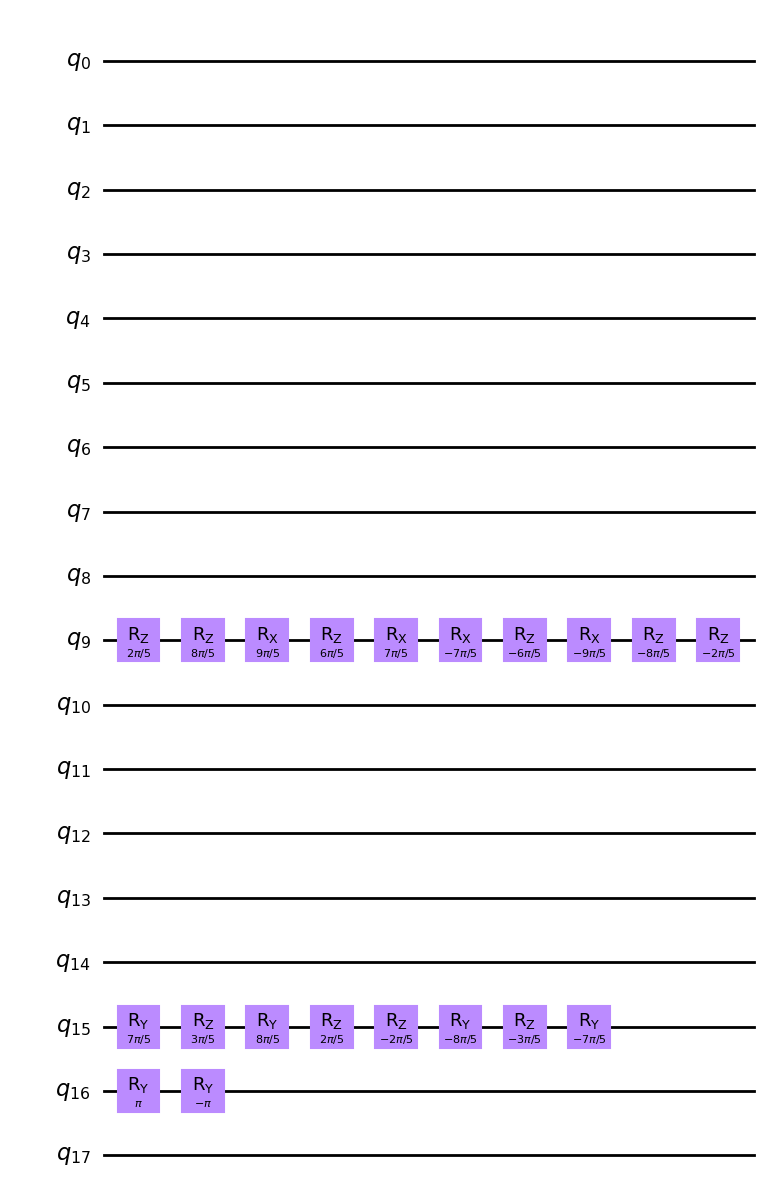

In [75]:
qiskits[0].draw('mpl')

In [76]:
test_data = []
for _qasm, real in zip(qasm, reals):
    test_data.append((_qasm, second, real)) 

In [86]:
test_data[0]

('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[18];\nrz(2*pi/5) q[9];\nry(7*pi/5) q[15];\nry(pi) q[16];\nry(-pi) q[16];\nrz(3*pi/5) q[15];\nrz(8*pi/5) q[9];\nry(8*pi/5) q[15];\nrx(9*pi/5) q[9];\nrz(2*pi/5) q[15];\nrz(6*pi/5) q[9];\nrz(-2*pi/5) q[15];\nrx(7*pi/5) q[9];\nry(-8*pi/5) q[15];\nrx(-7*pi/5) q[9];\nrz(-3*pi/5) q[15];\nrz(-6*pi/5) q[9];\nry(-7*pi/5) q[15];\nrx(-9*pi/5) q[9];\nrz(-8*pi/5) q[9];\nrz(-2*pi/5) q[9];\n',
 {'qubit': {0: {'T1': 143.00707506,
    'T2': 68.60893648,
    'prob_meas0_prep1': 0,
    'prob_meas1_prep0': 0},
   1: {'T1': 173.83609431,
    'T2': 23.66789366,
    'prob_meas0_prep1': 0,
    'prob_meas1_prep0': 0},
   2: {'T1': 194.26746865,
    'T2': 19.37538014,
    'prob_meas0_prep1': 0,
    'prob_meas1_prep0': 0},
   3: {'T1': 116.13005113,
    'T2': 26.07907702,
    'prob_meas0_prep1': 0,
    'prob_meas1_prep0': 0},
   4: {'T1': 172.04279259,
    'T2': 17.78826406,
    'prob_meas0_prep1': 0,
    'prob_meas1_prep0': 0},
   5: {'T1': 176.46327618,
    'T2': 2

In [77]:
with open ('compare_4_28_test_data.pkl', 'wb') as f:
    pickle.dump(test_data,f)